In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Import data prepared in previous steps (only data for 2018 survey, full time employment, and removed outliers) and used for all machine learning models. The target is hourly rate and predictors are economic sector (nace), company size (esize_class), gender, age class, profession (lpk), education. All these are categorical variables. Single numerical variable is experience in years.

In [2]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') 
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


One fifth of records is kept for testing of models.

In [3]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:', 'train', len(y_train), ', test', len(y_test))

Dataset lengths: train 26114 , test 6529


# Model and predictions

## Initial Random Forest model

Initial Random Forest model used to test pipline and estimate the baseline accuracy. Numerical feature is scaled with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and categorical features are encoded using [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) with automatically determined categories.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("ordinal", OrdinalEncoder())])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ],
    sparse_threshold=0
)

model = Pipeline([('prep', preprocessor), ('regr', RandomForestRegressor())])
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr', RandomForestRegressor())])

Function to print model prediction RMSE and R2

In [7]:
def print_model_rmse_r2(model, X_train, y_train, X_test, y_test):
    """ 
    Function to print model prediction RMSE and R2
    for train and test datasets
        Parameters:
        model - model to evaluate
        X_train - train features
        y_train - train target 
        X_test - test features
        y_test - test target
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)

    r2_train = r2_score(y_train, y_train_pred).round(3)
    r2_test = r2_score(y_test, y_test_pred).round(3)

    print('Train: RMSE=', rmse_train, ' R2=', r2_train,
        '\nTest: RMSE=', rmse_test, ' R2=', r2_test)

RMSE and R2 of initial model predicions for train and test datasets.

In [8]:
print_model_rmse_r2(model, X_train, y_train, X_test, y_test)

Train: RMSE= 0.834  R2= 0.893 
Test: RMSE= 1.687  R2= 0.559


Initial model has very low bias and high variance.

## Randomized Search CV with Random Forest

We used Randomized Search cross validation to tune RF model hyparameters.

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
model = Pipeline([('prep', preprocessor), ('regr', RandomForestRegressor())])

grid = {
        'regr__max_depth': np.arange(10, 16, 1, dtype=int),
        'regr__min_samples_leaf': np.arange(8, 15, 1, dtype=int),
        'regr__min_samples_split': np.arange(3, 8, 1, dtype=int),
        'regr__n_estimators': np.arange(600, 800, 50, dtype=int),
        'regr__ccp_alpha': np.logspace(-6,-3, 4),
         }
search = RandomizedSearchCV(model, grid, scoring='neg_root_mean_squared_error', n_iter = 50, cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)

results_pd = pd.DataFrame(results.cv_results_)
results_pd.filter(regex='rank|regr|mean_test_score|std_test_score',axis=1).sort_values('rank_test_score').head().T

,10,35,46,43,49
param_regr__n_estimators,650,750,650,750,700
param_regr__min_samples_split,4,7,4,6,6
param_regr__min_samples_leaf,8,8,8,9,9
param_regr__max_depth,14,15,13,15,14
param_regr__ccp_alpha,0.000001,0.0001,0.00001,0.0001,0.00001
mean_test_score,-1.671302,-1.671472,-1.672024,-1.672975,-1.673133
std_test_score,0.026965,0.02705,0.027039,0.02702,0.027447
rank_test_score,1,2,3,4,5


In [10]:
best_model=results.best_estimator_
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 RandomForestRegressor(ccp_alpha=1e-06, max_depth=14,
                                       min_samples_leaf=8, min_samples_split=4,
                                       n_estimators=650))])

In [11]:
print_model_rmse_r2(best_model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.459  R2= 0.671 
Test: RMSE= 1.619  R2= 0.594


For top 5 iterations the max depth between 14 and 16. The small ccp_alpha values 1e-6 - 1e-4  were used for top  iterations. Best number of estimators is between 650 and 750. The min  amples split and leaf varies more, but the resulting variation in test score is small, thus the potential to improve model is small as well. The model with parameters from best iteration will be used for further analysis.

## Feature importance 

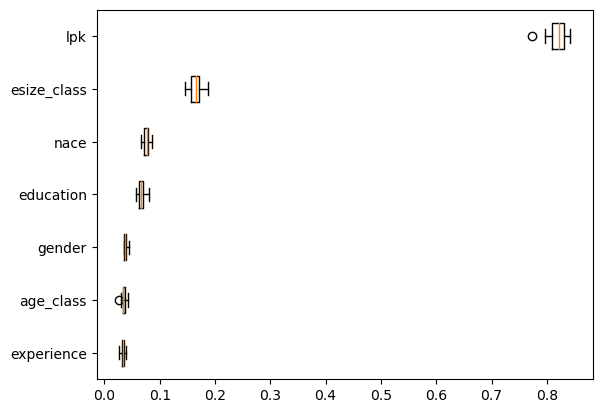

In [12]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_test, y_test,  n_repeats=30,  random_state=0)
importance_order = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.boxplot(
    perm_importance.importances[importance_order].T,
    vert=False,
    labels=np.array(X_test.columns)[importance_order],
);

The most important feature by far is profession (lpk) followed by company size. The economic sector, education, gender experience and age are less important. Feature immportance might be affected by large cardinality of lpk and nace.

# Model (Pipline) Serialization 

In [13]:
import joblib
joblib.dump(best_model, './Models/RF_model.joblib')

['./Models/RF_model.joblib']